# Topic representation and visualization
Here I improve the base representation adding stopwords, and visualize topics in the produced models.

This step was performed after training, to speed up the training process.

In [1]:
import sys
import os

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
)  # Adjust as needed
sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), "..", "..", "scripts"))
)  # Adjust as needed
import pandas as pd
import numpy as np
from scripts.my_text_cleaning import clean_dataframe
from scripts.parallel_topic_model import deduplicate_text_and_embeddings
import logging
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
# set global logging level to WARNING
logging.getLogger().setLevel(logging.WARNING)

In [2]:
chosen_dataset = "cop26_tweets_en"
chosen_dataset = "ukraine_tweets_en"
chosen_dataset = "covid_tweets_en"
ur_df = pd.read_parquet("./../../data/raw/" + chosen_dataset + ".parquet")
doc_info = pd.read_csv(
    "./../../data/processed/document_info_" + chosen_dataset + ".csv"
)[["Document", "Topic", "Representative_document", "Name"]]
topic_info = pd.read_csv(
    "./../../data/processed/topic_info_" + chosen_dataset + ".csv"
)
if "Unnamed: 0" in topic_info.columns:
    topic_info.drop(columns=["Unnamed: 0"], inplace=True)
doc_info.Topic = doc_info.Topic.astype(int)
embeddings = np.load("./../../data/processed/" + chosen_dataset + ".parquet.npy")
cln_df = clean_dataframe(
    ur_df, 
    'text',
    phrases_to_remove=["&gt;", "&lt;", "&amp;", "RT : "],
    remove_empty=False,
    remove_urls=True,
    normalize_hashtags=True,
    normalize_mentions=True,
    user_placeholder="user",
    strip_punctuation=False,
    lowercase=False,
    )
unique_docs, _ = deduplicate_text_and_embeddings(cln_df, None, 'Cleantext')
topic_model = BERTopic.load(
    "./../../models/" + chosen_dataset + ".parquet.topic_model",
    embedding_model="all-mpnet-base-v2",
)
print(f"{len(cln_df)=}")
print(f"{len(unique_docs)=}")
print(f"{len(doc_info)=}")
print(f"{len(topic_info)=}")

len(cln_df)=607192
len(unique_docs)=545032
len(doc_info)=545032
len(topic_info)=165


Choosing the stopwords for representation, I choose english and spanish stopwords, html escapes, the mention replacement and the RT boilerplate text.
Spanish was added to gain insights on the contents on the non-english topics found using bertopic, usually limited to one small topic, being the data in english.
Moreover, dataset-specific words were chosen. Ideally the dataset-specific words should contain all hashtags and keywords used to download the data.

In [3]:
# Get English + Spanish stopwords
stopwords_en = stopwords.words("english")
stopwords_es = stopwords.words("spanish")
data_specific_stopwords = []
if chosen_dataset == "covid_tweets_en":
    data_specific_stopwords = [
        "covid",
        "covid19",
        "coronavirus",
        #"pandemic",
        #"virus",
        #"people",
        #"get",
        #"like",
        #"one",
        #"new",
        #"cases",
        #"health",
        #"vaccine",
        #"vaccines",
        #"vaccinated",
        #"deaths",
        #"time",
        #"year",
        #"day",
        #"years",
    ]
elif chosen_dataset == "ukraine_tweets_en":
    data_specific_stopwords = [
        "ukraine",
        "russia",
        #"war",
        #"russian",
        #"people",
        #"like",
        #"one",
        #"get",
        #"just",
        #"know",
        #"time",
        #"day",
        #"year",
        #"years",
        #"donbas",
        #"ukrainian",
        #"military",
        #"ukrainians",
        #"today",
    ]
elif chosen_dataset == "cop26_tweets_en":
    data_specific_stopwords = [
        "cop26",
        #"climate",
        #"people",
        #"like",
        #"one",
        #"get",
        #"just",
        #"know",
        #"time",
        #"day",
        #"year",
        #"years",
        #"action",
        #"change",
        #"global",
        #"world",
        #"new",
        #"need",
    ]
custom_stopwords = set(
    stopwords_en + stopwords_es + ["http", "https", "amp", "www", "com"] + ["user", 'rt'] + data_specific_stopwords
)

To represent the topics, I choose two representation models, the base one and the Maxumum Marginal Relevance (MMR).

MMR increases the likelyhood of picking words that are not repetitions (e.g. german, germany).

In [4]:
docs_clean = doc_info.Document.tolist()
topics = (doc_info.Topic.tolist())
vectorizer_model = CountVectorizer(stop_words=list(custom_stopwords))

representation_models = {
    "MMR": MaximalMarginalRelevance(diversity=0.7)
}

topic_model.update_topics(
    docs=docs_clean, topics=topics, vectorizer_model=vectorizer_model, representation_model=representation_models
)


2025-09-19 14:58:39,534 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [5]:
new_topic_info = topic_model.get_topic_info()
new_topic_info['New_Name'] = new_topic_info.apply(
    lambda row: str(row['Topic']) + "_" + "_".join(row['Representation']),
    axis=1
)
new_topic_info['New_Name_MMR'] = new_topic_info.apply(
    lambda row: str(row['Topic']) + "_" + "_".join(row['MMR']),
    axis=1
)

merged_topic_info = topic_info.drop(columns=["Representation"]).merge(
    new_topic_info[["Topic", 'MMR', "New_Name", "Representation", "New_Name_MMR"]], on="Topic", suffixes=("_old", "_new")
)

#merged_topic_info.to_csv(
#    "./../../data/processed/topic_info_" + chosen_dataset + "_with_MMR.csv", index=False
#)

## Visualize Topics

In [6]:
top_n_topics = 20
fig = topic_model.visualize_barchart(top_n_topics=top_n_topics, title="Top 20 topics")

# Suppose 'labels' is the number of bars or subplots
# Use the new API to get the colormap
cmap = plt.get_cmap("tab20", top_n_topics)  # or: cmap = plt.colormaps["tab20"]

# Convert RGBA to hex for Plotly
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) 
          for r, g, b, a in cmap(range(top_n_topics))]

# Assign colors to traces
for i, trace in enumerate(fig.data):
    trace.marker.color = colors[i % len(colors)]  # cycles if more traces than labels
fig.show()


### Topic distribution

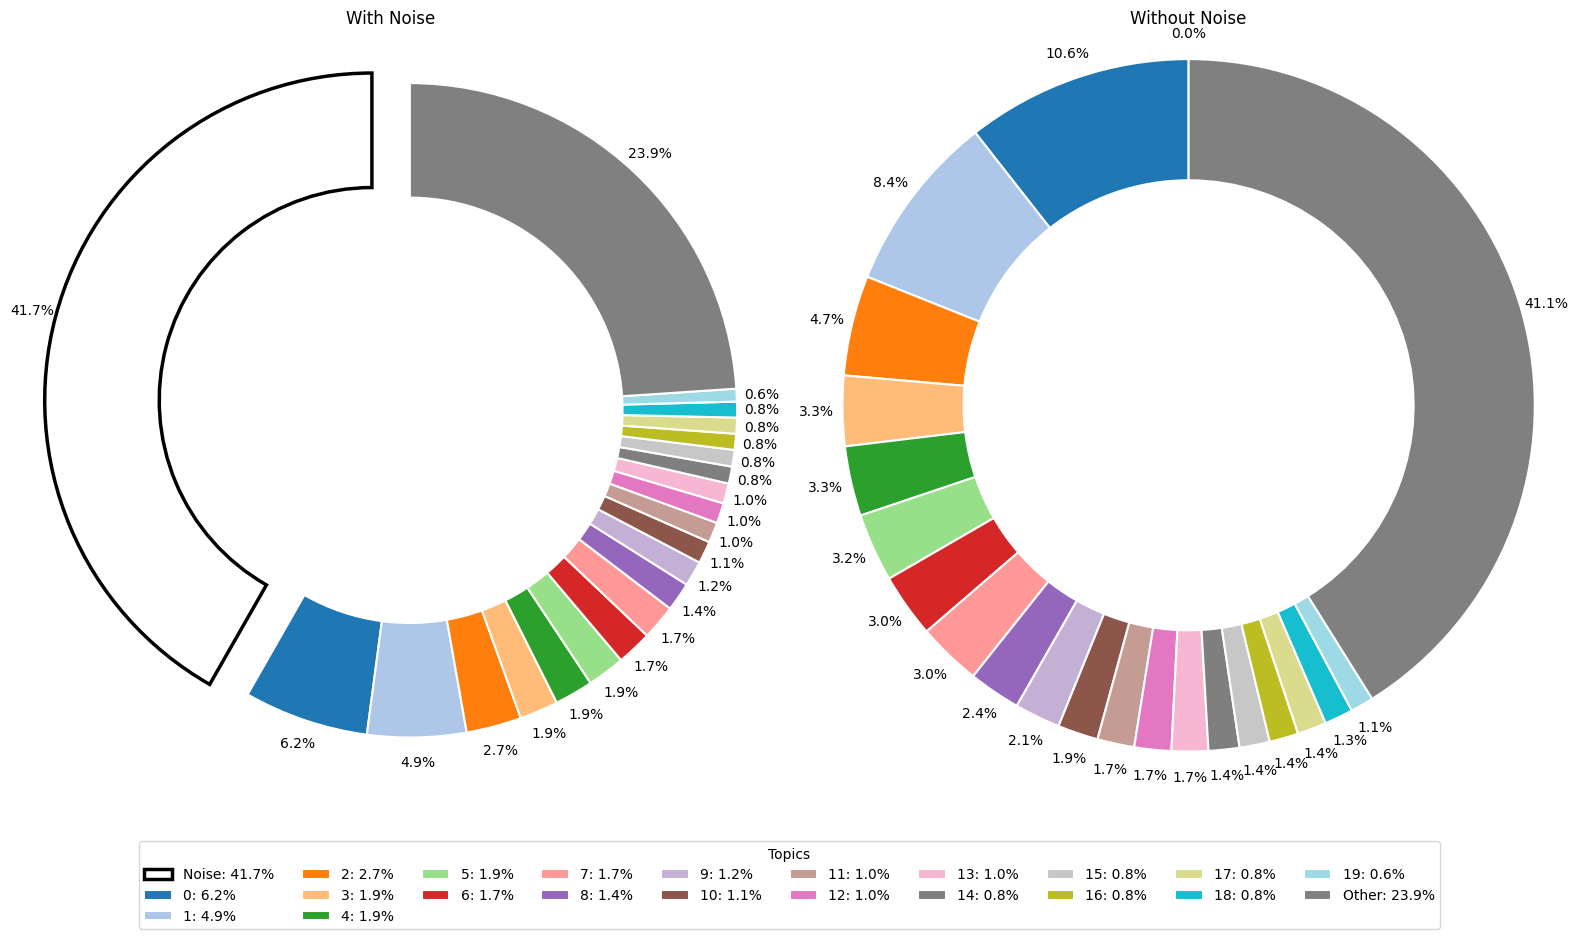

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy and sanitize
df = merged_topic_info.copy()
df['Topic'] = pd.to_numeric(df['Topic'], errors='coerce')  # ensure numeric

# ---------- Prepare first chart (with noise) ----------
df_with_noise = df.copy()
df_with_noise['Topic_Grouped'] = df_with_noise['Topic'].apply(
    lambda x: 'Other' if pd.notna(x) and x >= top_n_topics else str(int(x)) if pd.notna(x) else 'Unknown'
)

grouped_noise = df_with_noise.groupby('Topic_Grouped', as_index=False)['Count'].sum()
grouped_noise = grouped_noise.sort_values('Count', ascending=False).reset_index(drop=True)
if 'Other' in grouped_noise['Topic_Grouped'].values:
    other_row = grouped_noise[grouped_noise['Topic_Grouped'] == 'Other']
    grouped_noise = grouped_noise[grouped_noise['Topic_Grouped'] != 'Other']
    grouped_noise = pd.concat([grouped_noise, other_row], ignore_index=True)

labels = grouped_noise['Topic_Grouped'].tolist()
sizes_noise = grouped_noise['Count'].tolist()

# Explode noise slice so it stands out
explode = [0.12 if lbl == '-1' else 0.0 for lbl in labels]

cmap = plt.get_cmap("tab20", len(labels))
colors_noise = []
for i, lbl in enumerate(labels):
    if lbl == "Other":
        colors_noise.append("gray")
    elif lbl == "-1":
        colors_noise.append("white")
    else:
        colors_noise.append(cmap(i))

# ---------- Prepare second chart (without noise) ----------
df_no_noise = df[df['Topic'] != -1].copy()
df_no_noise['Topic_Grouped'] = df_no_noise['Topic'].apply(
    lambda x: 'Other' if pd.notna(x) and x >= top_n_topics else str(int(x)) if pd.notna(x) else 'Unknown'
)

grouped_no_noise = df_no_noise.groupby('Topic_Grouped', as_index=False)['Count'].sum()
grouped_no_noise = grouped_no_noise.sort_values('Count', ascending=False).reset_index(drop=True)
if 'Other' in grouped_no_noise['Topic_Grouped'].values:
    other_row = grouped_no_noise[grouped_no_noise['Topic_Grouped'] == 'Other']
    grouped_no_noise = grouped_no_noise[grouped_no_noise['Topic_Grouped'] != 'Other']
    grouped_no_noise = pd.concat([grouped_no_noise, other_row], ignore_index=True)

sizes_no_noise = []
for lbl in labels:  # use the same label order as the first chart
    if lbl in grouped_no_noise['Topic_Grouped'].values:
        sizes_no_noise.append(int(grouped_no_noise.loc[grouped_no_noise['Topic_Grouped'] == lbl, 'Count']))
    else:
        sizes_no_noise.append(0)  # keep alignment

colors_no_noise = []
for i, lbl in enumerate(labels):
    if lbl == "Other":
        colors_no_noise.append("gray")
    else:
        colors_no_noise.append(cmap(i))

# ---------- Plot side-by-side donut charts ----------
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First chart: with noise
wedges1, texts1, autotexts1 = axes[0].pie(
    sizes_noise,
    labels=None,
    autopct='%1.1f%%',
    colors=colors_noise,
    startangle=90,
    explode=explode,
    pctdistance=1.075,
    wedgeprops=dict(width=0.35, edgecolor='w', linewidth=1.5)
)
for i, lbl in enumerate(labels):
    if lbl == "-1":
        wedges1[i].set_edgecolor("black")
        wedges1[i].set_linewidth(2.5)
for autotext in autotexts1:
    autotext.set_color('black')
    autotext.set_fontsize(10)
axes[0].axis('equal')
axes[0].set_title("With Noise")

# Second chart: without noise
wedges2, texts2, autotexts2 = axes[1].pie(
    sizes_no_noise,
    labels=None,
    autopct='%1.1f%%',
    colors=colors_no_noise,
    startangle=90,
    pctdistance=1.075,
    wedgeprops=dict(width=0.35, edgecolor='w', linewidth=1.5)
)
for autotext in autotexts2:
    autotext.set_color('black')
    autotext.set_fontsize(10)
axes[1].axis('equal')
axes[1].set_title(f"Without Noise")

# ---------- Shared legend based on first chart ----------
percentages = [f"{p:.1f}%" for p in (grouped_noise['Count'] / grouped_noise['Count'].sum() * 100)]
legend_labels = [f"{lab}: {pct}" if lab not in ["Other", "-1"]
                 else (f"Other: {pct}" if lab == "Other" else f"Noise: {pct}")
                 for lab, pct in zip(labels, percentages)]
fig.legend(wedges1, legend_labels, title="Topics", loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

plt.tight_layout()
plt.show()


### Top 20 Frequent & MMR Words
MMR = Maximum Marginal Relevance.
Increases the likelihood that the words chosen to represent a topic are different (e.g. only one between *thank* and *thanks* is chosen) without lemmatizing the whole corpus.

In [8]:
import ast
# print top 20 topics
for topic_num in range(-1,20):
    print(f"Topic {topic_num}:")
    print("  Base:", merged_topic_info.loc[merged_topic_info.Topic == topic_num]["Representation"].values[0])
    print("  MMR:", merged_topic_info.loc[merged_topic_info.Topic == topic_num]["MMR"].values[0])
    representative_docs = ast.literal_eval(merged_topic_info[merged_topic_info.Topic == topic_num]["Representative_Docs"].values[0])
    for d in representative_docs:
        print("    -", d)
    print()

Topic -1:
  Base: ['vaccine', 'dose', 'vaccines', '19', 'pfizer', 'people', 'get', 'moderna', 'new', 'one']
  MMR: ['vaccine', 'moderna', 'one', 'astrazeneca', 'us', 'today', 'data', 'said', 'johnson', 'could']
    - RT user: user I received the first dose of the Pfizer vaccine 2 1/2 weeks ago and am scheduled to have the second dose th…
    - RT user: AstraZeneca vaccine: EU agency says AstraZeneca is 'safe and effective'
    - user user user user user user user user user user user user user user user user user user user user user user Great work, I can find all the RCTs for potential therapeutic agents in COVID19 here COVID19 COVID19RX Check here a study of high dose vit C in COVID19

Topic 0:
  Base: ['cases', 'lockdown', 'deaths', 'virus', 'boris', 'pandemic', 'new', 'uk', 'variant', 'brexit']
  MMR: ['boris', 'pandemic', 'new', 'uk', 'restrictions', 'people', 'stay', '000', 'wave', 'test']
    - Myth: Virus is weak. COVID’s gone Speed: First 500,000 cases =140 days Last 500k cases